# 6.基因聚类与KEGG

In [1]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scvelo as scv
import velovgi

Global seed set to 0
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 1. 数据读入

In [2]:
subsample_adata = scv.read("./data/subsample_adata.h5ad") # 额外读取
adata = velovgi.tl.read_adata("./data/adata/")

batch_key = "stage"
cluster_key = "celltype"
pseudotime_key = "velocity_pseudotime"
subsample_adata, adata

load ./data/adata//adata.h5ad
load ./data/adata//sample_recover.pkl


(AnnData object with n_obs × n_vars = 250 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
     uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'neighbors'
     obsm: 'X_pca', 'X_umap'
     layers: 'Ms', 'Mu', 'fit_t', 'latent_time_velovgi', 'spliced', 'unspliced', 'velocity', 'velocity_u'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 500 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
     var: 'Accession', 'Chromosome', 

## 2. 基因聚类

In [12]:
# 使用转换后的结果进行基因聚类
import seaborn as sns
from sklearn.cluster import KMeans

# 基因分类
k = 3

top_genes = list(adata.var.index[:2000])
cm = scv.pl.heatmap(adata, var_names=top_genes, sortby="velocity_pseudotime", sort=True, col_color=[cluster_key, "velocity_pseudotime"], n_convolve=100, show=False) # 保存平滑之后的结果
df = cm.data2d # 这里提取出clustermap的结果
A = df.T.corr(method="pearson") # pearson相关性作为特征
classifier = KMeans(n_clusters=k, random_state=0).fit(A)
gene_cluster_list = classifier.labels_

# # 手动设置
# sep = int(len(top_genes)/k)
# for i in range(k):
#     gene_cluster_list[i*sep: (i+1)*sep] = i

# 颜色转换
color_dict = dict(enumerate(sns.palettes.color_palette()[:k]))
color_list = list(map(lambda x: color_dict[x], gene_cluster_list))

scv.pl.heatmap(adata, var_names=top_genes, sortby="velocity_pseudotime", col_color=[cluster_key, "velocity_pseudotime"], n_convolve=100, row_colors = color_list)

## 3. 基因聚类的平均值变化情况

([], [])

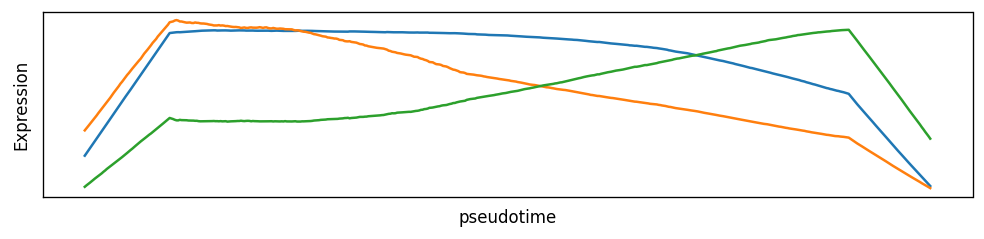

In [ ]:
import matplotlib.pyplot as plt

A["gene_cluster"] = gene_cluster_list # 添加最后一列
mean_df = A.groupby("gene_cluster").mean().iloc[:, :-1].T # 去除最后一列

plt.figure(figsize=(10, 2), dpi=120)

for i in range(k):
    plt.plot(mean_df[i], color=color_dict[i])

plt.xlabel("pseudotime")
plt.xticks([])
plt.ylabel("Expression")
plt.yticks([])

## 4. KEGG富集成表格

In [5]:
import gseapy as gp


# 抽取各个聚类的基因名列表
gene_list_dict = {}
for i in range(k):
    gene_list = list(adata.var.index[gene_cluster_list==i])
    gene_list_dict[i] = gene_list

# 对各个聚类执行富集
kegg_df_dict = {}
for i in gene_list_dict.keys():
    print(i)
    kegg_df = gp.enrichr(gene_list_dict[i], gene_sets="KEGG_2019_Mouse").res2d
    kegg_df_dict[i] = kegg_df

kegg_df_dict[0]

0
1
2


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Mouse,Ribosome,42/170,1.694311e-16,4.489923e-14,0,0,5.702198,2.070701e+02,RPL4;MRPS15;RPL3;RPL32;RPLP1;RPL12;RPLP0;RPL36...
1,KEGG_2019_Mouse,Spliceosome,35/132,5.521867e-15,7.316474e-13,0,0,6.240341,2.048708e+02,RBM25;DDX46;EFTUD2;SNRPD2;TRA2B;MAGOH;TRA2A;HN...
2,KEGG_2019_Mouse,Cell cycle,29/123,2.790072e-11,2.464563e-09,0,0,5.307118,1.289755e+02,YWHAB;HDAC1;CUL1;SMC3;CDC20;ORC5;ORC4;CCND3;CC...
3,KEGG_2019_Mouse,RNA transport,32/167,8.225998e-10,5.449724e-08,0,0,4.079910,8.534581e+01,CYFIP1;POP5;EIF4A1;NUP160;MAGOH;EIF4E;EIF2B5;N...
4,KEGG_2019_Mouse,Nucleotide excision repair,13/43,3.801965e-07,2.015042e-05,0,0,7.371751,1.089735e+02,RFC3;LIG1;RFC1;GTF2H2;RAD23B;GTF2H5;RBX1;POLD3...
...,...,...,...,...,...,...,...,...,...,...
260,KEGG_2019_Mouse,Inflammatory mediator regulation of TRP channels,1/127,9.993542e-01,9.999960e-01,0,0,0.132887,8.584468e-05,GNAS
261,KEGG_2019_Mouse,Cell adhesion molecules (CAMs),1/170,9.999440e-01,9.999960e-01,0,0,0.098848,5.538741e-06,ITGB1
262,KEGG_2019_Mouse,Olfactory transduction,1/1133,9.999941e-01,9.999960e-01,0,0,0.013998,8.210726e-08,GNB1
263,KEGG_2019_Mouse,Neuroactive ligand-receptor interaction,1/348,9.999959e-01,9.999960e-01,0,0,0.047684,1.977323e-07,F2R


In [6]:
# 看看此处富集的通路与CellDancer中哪些出现了
pathway_list = [
    "Angiogenesis",
    "Vasculogenesis",
    "Wound healing",
    "Actin cytoskeleton organization",
    "Cell division",
    "Cell cycle",
    "Chromatin organization",
    "RNA splicing",
    "Translation",
    "Carboxylic acid metabolic process",
    "Erythrocyte development",
    "Heme biosynthetic process",
    "Oxygen transport",
    "Cellular oxidant detoxification"
]
for i in kegg_df_dict.keys():
    print(i)
    kegg_df = kegg_df_dict[i]
    for term in kegg_df["Term"]:
        if term in pathway_list:
            print(term)
# 出现的并不多，那暂时自己找几个吧

0
Cell cycle
1
Cell cycle
2
Cell cycle


In [7]:
for i in kegg_df_dict.keys():
    print(kegg_df_dict[i].head()["Term"])

0                      Ribosome
1                   Spliceosome
2                    Cell cycle
3                 RNA transport
4    Nucleotide excision repair
Name: Term, dtype: object
0                        RNA transport
1                          Spliceosome
2    Ribosome biogenesis in eukaryotes
3                           Cell cycle
4                             Ribosome
Name: Term, dtype: object
0                            Cell cycle
1                              Ribosome
2                         RNA transport
3    Cysteine and methionine metabolism
4                 Riboflavin metabolism
Name: Term, dtype: object


,RNA transport,Cell cycle,Ribosome,Homologous recombination,Ribosome
0,5.449724e-08,2.464563e-09,4.489923e-14,0.716839,4.489923e-14
1,3.244383e-16,7.118063e-07,1.693674e-06,0.352541,1.693674e-06
2,3.887806e-02,1.094872e-02,1.094872e-02,0.478101,1.094872e-02


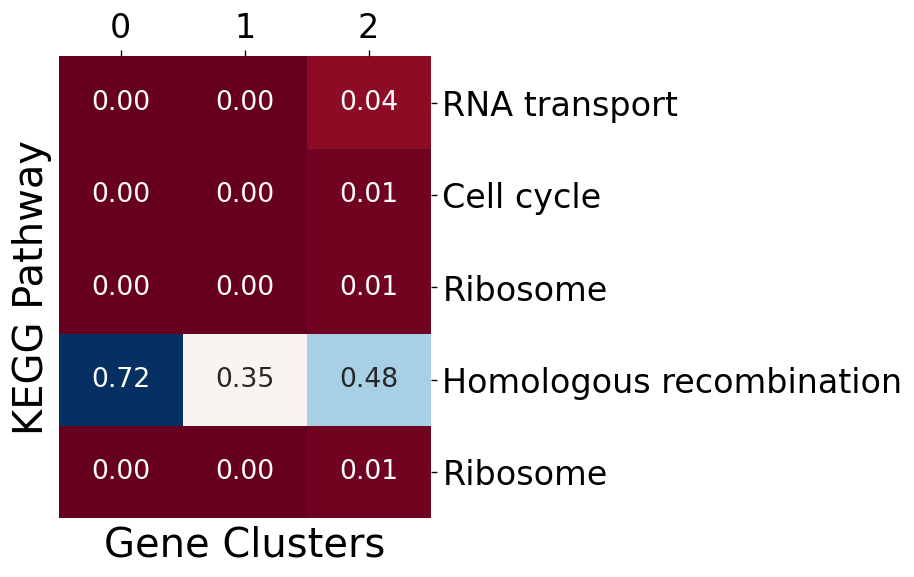

In [8]:
import numpy as np
import pandas as pd

plt.figure(figsize=(4,5), dpi=120)
pathway_list = [
    "RNA transport",
    "Cell cycle",
    "Ribosome",
    "Homologous recombination",
    "Ribosome",
]

df = pd.DataFrame(np.ones((k, len(pathway_list))), columns=pathway_list)

for i in kegg_df_dict.keys():
    kegg_df = kegg_df_dict[i]
    for pathway in pathway_list:
        if pathway in list(kegg_df["Term"]):
            pvalue = float(kegg_df[kegg_df["Term"] == pathway]["Adjusted P-value"])
            df.loc[i,pathway] = pvalue # 有该通路则更新值

# 表格还需要美化
ax = sns.heatmap(df.T, annot=True, fmt=".2f", cbar=False, cmap="RdBu", annot_kws={"fontsize":16}, )

ax.xaxis.set_ticks_position("top") 
ax.yaxis.set_ticks_position("right") 
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)

plt.xlabel("Gene Clusters", fontsize=24)
plt.ylabel("KEGG Pathway", fontsize=24)
df

## 5. 色带绘制

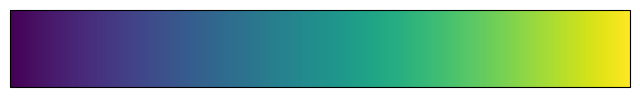

In [9]:
import matplotlib as mpl

# 基因表达随时间变化色带
fig, ax = plt.subplots(1, 1, figsize=(8, 1))
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=1)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# 干脆文字部分都不要了
cbar = fig.colorbar(
    im, cax=ax, orientation="horizontal",
    ticks=[],
)

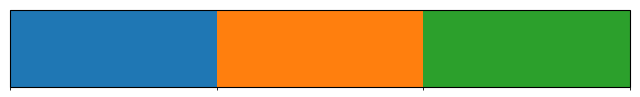

In [10]:
# 基因聚类色带
colors = color_dict.values()
fig, ax = plt.subplots(figsize=(8, 1))
cmap = mpl.colors.ListedColormap(colors) # 指定离散颜色
bounds = range(len(colors)+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig.colorbar(
    im, cax=ax, orientation="horizontal",
    ticks=[]
)

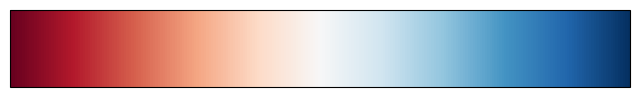

In [11]:
# 显著性色带
fig, ax = plt.subplots(1, 1, figsize=(8, 1))
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=0, vmax=1)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

cbar = fig.colorbar(
    im, cax=ax, orientation="horizontal",
    ticks=[],
)